#Assignment_2

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import urllib.request


In [2]:
def load_image(image_url):
    """Load image in grayscale"""
    resp = urllib.request.urlopen(image_url)
    image_array = np.asarray(bytearray(resp.read()), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_GRAYSCALE)
    return image

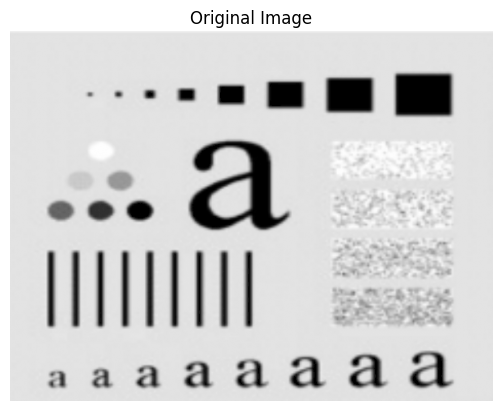

In [3]:
# Provide the image URL
image_url = "https://drive.google.com/uc?id=1PKCyYW9FWhsQUchwjSlwQYsmoSASdFSy"
image = load_image(image_url)

# Display Original Image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()


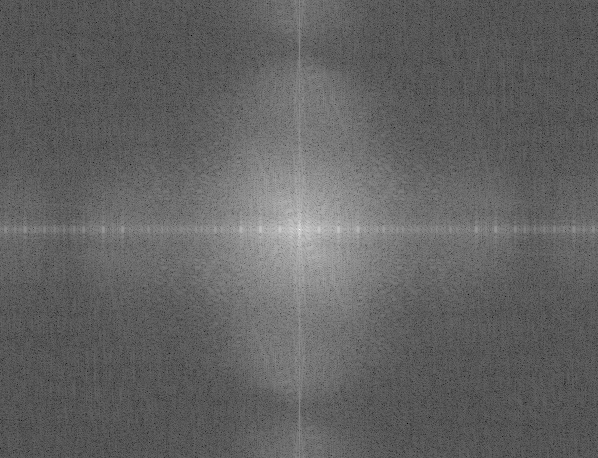

In [4]:
# Compute the discrete Fourier Transform of the image
fourier = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)

# Shift the zero-frequency component to the center of the spectrum
fourier_shift = np.fft.fftshift(fourier)

# calculate the magnitude of the Fourier Transform
magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]))

# Scale the magnitude for display
magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

cv2_imshow(magnitude)


In [5]:
def apply_fourier_transform(image):
    """Compute the DFT and shift the zero-frequency component to the center"""
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    return dft_shifted

def inverse_fourier_transform(dft_shifted):
    """Reverse the Fourier transform and return the magnitude"""
    dft_shifted = np.fft.ifftshift(dft_shifted)  # Shift back
    img_back = cv2.idft(dft_shifted)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])  # Compute magnitude
    return cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)  # Normalize for display


def create_filter(shape, filter_type, d0=30, w=10):
    """
    Create various frequency filters in the frequency domain.
    - filter_type: 'lowpass', 'highpass', 'bandpass', 'bandstop'
    - d0: Cutoff frequency
    - w: Bandwidth for band filters
    """
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols, 2), np.float32)

    for u in range(rows):
        for v in range(cols):
            d = np.sqrt((u - crow)**2 + (v - ccol)**2)  # Distance from center
            if filter_type == 'lowpass' and d <= d0:
                mask[u, v] = 1
            elif filter_type == 'highpass' and d > d0:
                mask[u, v] = 1
            elif filter_type == 'bandpass' and d0 - w / 2 <= d <= d0 + w / 2:
                mask[u, v] = 1
            elif filter_type == 'bandstop' and not (d0 - w / 2 <= d <= d0 + w / 2):
                mask[u, v] = 1

    return mask


## Tune over different frequencies using **create_filter** function

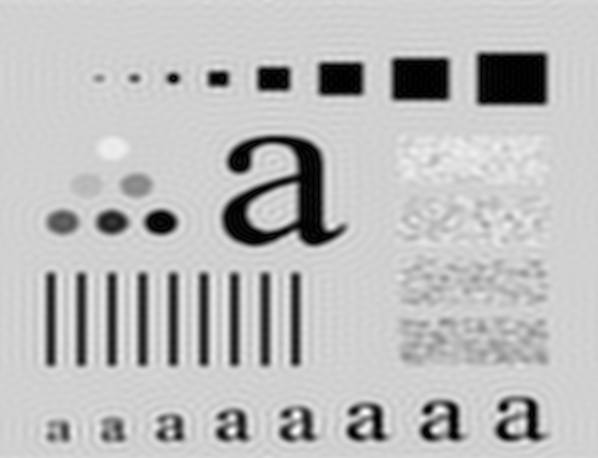

In [6]:
# Load image
path = "https://drive.google.com/uc?id=1PKCyYW9FWhsQUchwjSlwQYsmoSASdFSy"
image = load_image(path)

# Apply Fourier Transform
dft_shifted = apply_fourier_transform(image)

# Create Low-Pass Filter
lowpass_filter = create_filter(image.shape, 'lowpass', d0=50)

# Apply Filter
filtered_dft = dft_shifted * lowpass_filter

# Inverse Fourier Transform
img_lowpass = inverse_fourier_transform(filtered_dft)

# Display
cv2_imshow(img_lowpass)


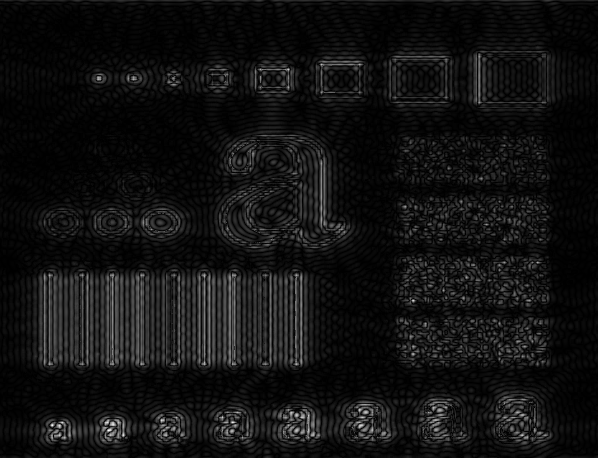

In [7]:
# Create High-Pass Filter
highpass_filter = create_filter(image.shape, 'highpass', d0=50)

# Apply Filter
filtered_dft = dft_shifted * highpass_filter

# Inverse Fourier Transform
img_highpass = inverse_fourier_transform(filtered_dft)

# Display
cv2_imshow(img_highpass)


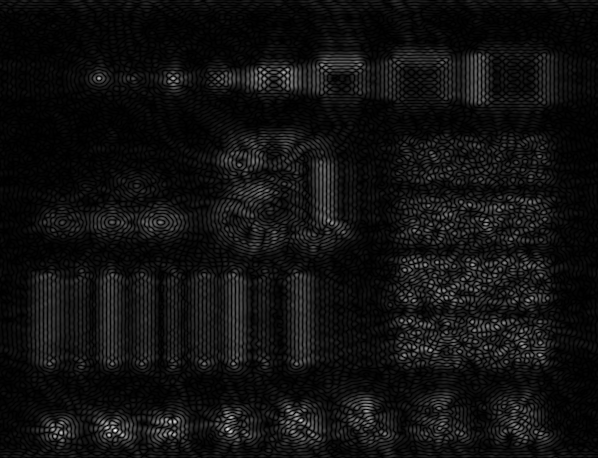

In [ ]:
# Create Band-Pass Filter
bandpass_filter = create_filter(image.shape, 'bandpass', d0=80, w=30)

# Apply Filter
filtered_dft = dft_shifted * bandpass_filter

# Inverse Fourier Transform
img_bandpass = inverse_fourier_transform(filtered_dft)

# Display
cv2_imshow(img_bandpass)


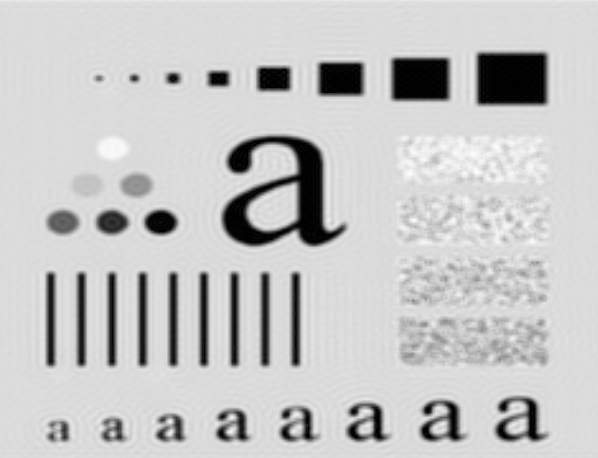

In [8]:
# Create Band-Stop Filter
bandstop_filter = create_filter(image.shape, 'bandstop', d0=80, w=30)

# Apply Filter
filtered_dft = dft_shifted * bandstop_filter

# Inverse Fourier Transform
img_bandstop = inverse_fourier_transform(filtered_dft)

# Display
cv2_imshow(img_bandstop)


## Update the **butterworth**, and **gaussian** parts in the following function





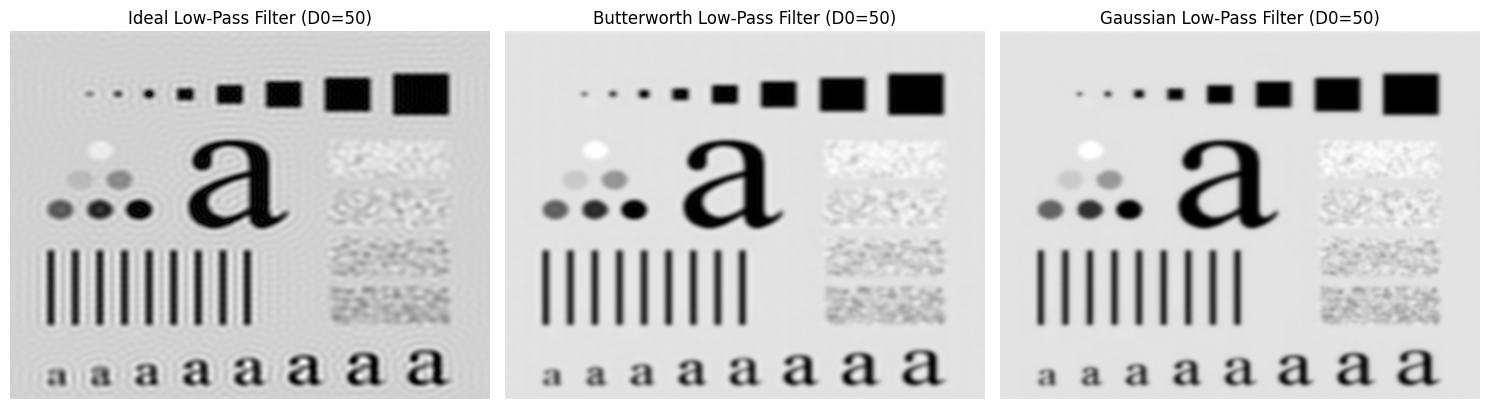

In [12]:
# Create Low-Pass Filters
def create_lowpass_filter(shape, filter_type, d0=30, order=2):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            d = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)  # Distance from center

            if filter_type == 'ideal':  # Ideal Low-Pass Filter
                mask[u, v] = 1 if d <= d0 else 0

            elif filter_type == 'butterworth':  # Butterworth Low-Pass Filter
                mask[u, v] = 1 / (1 + (d / d0) ** (2 * order))

            elif filter_type == 'gaussian':  # Gaussian Low-Pass Filter
                mask[u, v] = np.exp(-(d**2) / (2 * (d0 ** 2)))



    return mask


# Apply Fourier Transform
dft_shifted = apply_fourier_transform(image)

# Define filter types and frequency cutoff
filter_types = ['ideal', 'butterworth', 'gaussian']
d0 = 50  # Cutoff frequency

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Apply different low-pass filters and display results
for i, f_type in enumerate(filter_types):
    # Create Low-Pass Filter
    lowpass_filter = create_lowpass_filter(image.shape, f_type, d0=d0)

    # Apply Filter
    filtered_dft = dft_shifted * lowpass_filter[:, :, np.newaxis]  # Expand dimensions

    # Inverse Fourier Transform
    img_lowpass = inverse_fourier_transform(filtered_dft)

    # Display in subplot
    ax = axes[i]
    ax.imshow(img_lowpass, cmap='gray')
    ax.set_title(f'{f_type.capitalize()} Low-Pass Filter (D0={d0})')
    ax.axis('off')

# Show the figure
plt.tight_layout()
plt.show()


## Generate this plot:

![Image Description](https://drive.google.com/uc?id=1Ryif1rOhK2JVY70iw600_ha3geEzhIfP)


## Update the **create_lowpass_filter** function to support highpass and lowpass filters
### name the function **create_filter**



In [11]:
import math

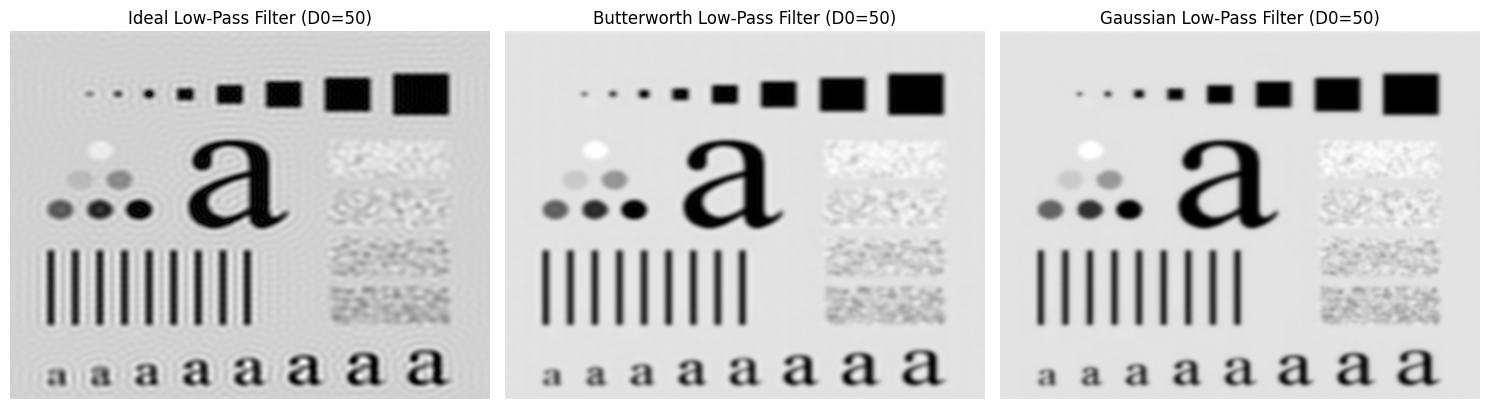

In [13]:
# Write the updated function here
# Create Low-Pass Filters
def create_lowpass_filter_after_updating(shape, filter_type, d0=30, order=2,  highpass = False):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.float32)

    for u in range(rows):
        for v in range(cols):
            d = np.sqrt((u - crow) ** 2 + (v - ccol) ** 2)  # Distance from center

            if filter_type == 'ideal':  # Ideal Low-Pass Filter
                mask[u, v] = 1 if d <= d0 else 0

            elif filter_type == 'butterworth':  # Butterworth Low-Pass Filter
                mask[u, v] = 1 / (1 + (d / d0) ** (2 * order))

            elif filter_type == 'gaussian':  # Gaussian Low-Pass Filter
                mask[u, v] = np.exp(-(d**2) / (2 * (d0 ** 2)))

            if highpass == True:
              mask[u, v] = 1 - mask[u, v]

    return mask


# Apply Fourier Transform
dft_shifted = apply_fourier_transform(image)

# Define filter types and frequency cutoff
filter_types = ['ideal', 'butterworth', 'gaussian']
d0 = 50  # Cutoff frequency

# Create figure for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Apply different low-pass filters and display results
for i, f_type in enumerate(filter_types):
    # Create Low-Pass Filter
    lowpass_filter = create_lowpass_filter(image.shape, f_type, d0=d0)

    # Apply Filter
    filtered_dft = dft_shifted * lowpass_filter[:, :, np.newaxis]  # Expand dimensions

    # Inverse Fourier Transform
    img_lowpass = inverse_fourier_transform(filtered_dft)

    # Display in subplot
    ax = axes[i]
    ax.imshow(img_lowpass, cmap='gray')
    ax.set_title(f'{f_type.capitalize()} Low-Pass Filter (D0={d0})')
    ax.axis('off')

# Show the figure
plt.tight_layout()
plt.show()


## Testing the new **create_filter** function

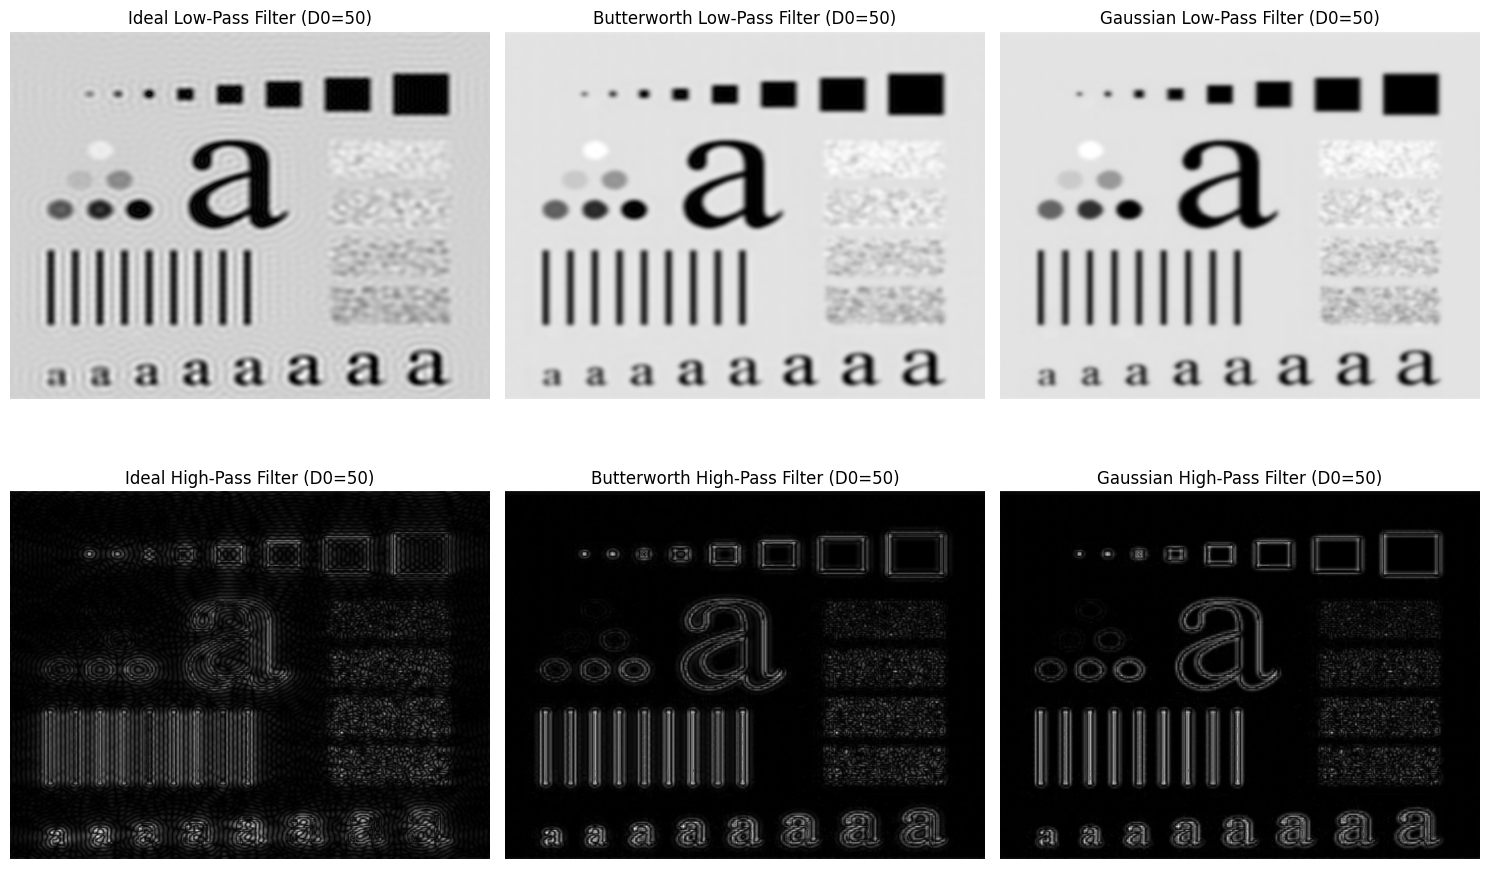

In [14]:
# Apply Fourier Transform
dft_shifted = apply_fourier_transform(image)

# Define filter types and frequency cutoff
filter_types = ['ideal', 'butterworth', 'gaussian']
d0 = 50  # Cutoff frequency

# Create figure for Low-Pass and High-Pass filters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Apply filters and display results
for i, f_type in enumerate(filter_types):
    # Low-Pass Filter
    lowpass_filter = create_lowpass_filter_after_updating(image.shape, f_type, d0=d0, highpass=False)
    filtered_dft_low = dft_shifted * lowpass_filter[:, :, np.newaxis]  # Expanding to match shape

    img_lowpass = inverse_fourier_transform(filtered_dft_low)

    # High-Pass Filter
    highpass_filter = create_lowpass_filter_after_updating(image.shape, f_type, d0=d0, highpass=True)
    filtered_dft_high = dft_shifted * highpass_filter[:, :, np.newaxis]  # Expanding to match shape

    img_highpass = inverse_fourier_transform(filtered_dft_high)

    # Display Low-Pass Filter Result
    axes[0, i].imshow(img_lowpass, cmap='gray')
    axes[0, i].set_title(f'{f_type.capitalize()} Low-Pass Filter (D0={d0})')
    axes[0, i].axis('off')

    # Display High-Pass Filter Result
    axes[1, i].imshow(img_highpass, cmap='gray')
    axes[1, i].set_title(f'{f_type.capitalize()} High-Pass Filter (D0={d0})')
    axes[1, i].axis('off')

# Show the figure
plt.tight_layout()
plt.show()

so , we have applied the  frequency domain filtering to an image using the Discrete Fourier Transform (DFT). It demonstrates low-pass, high-pass, band-pass, and band-stop filtering using ideal, Butterworth, and Gaussian methods. The filters help analyze and manipulate image frequency components, enhancing or suppressing specific details.